<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/Linearized_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 227 (delta 18), reused 10 (delta 4), pack-reused 191
Receiving objects: 100% (227/227), 21.48 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [2]:
! ls

Neural_Tangent_Kernel  sample_data


# Apply the results from the linearized network paper to the experiments in Neural Tangent Kernel paper

## Same setup as section 6.2

Start from the simple example of the 4 elements, and apply the formulas from the linearized network paper to compare with the analytical dynammics of the weights and the  network function. 


**NOTE**: _the code in this notebook is quite messy and there may be big confusions with the fact that both np arrays and torch tensors are used, as well as some reshaping ad hoc. Keep this in mind when adapting this code to other examples._


In [0]:
from google.colab import files

In [0]:
import numpy as np

from scipy.linalg import eig

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import time

In [0]:
import seaborn as sns
sns.set()

In [0]:
from collections import OrderedDict

In [0]:
import sys
sys.path.append("../")
from Neural_Tangent_Kernel.src.NTK_net import LinearNeuralTangentKernel, FourLayersNet, train_net, circle_transform, variance_est, cpu_tuple, kernel_mats

In [8]:
use_cuda = True if torch.cuda.is_available() else False
use_cuda

True

### Define the input and target data, together with some test data

In [0]:
gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))
n_train = len(gamma_data)
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()
input_data = circle_transform(gamma_data)
if use_cuda:
  input_data = input_data.cuda()
  target_data = target_data.cuda()

In [0]:
gamma_test = torch.tensor(np.linspace(-np.pi, np.pi, 10))  # we take only 10 test points where to study the predictions. 
n_test = len(gamma_test)
test_data = circle_transform(gamma_test)
if use_cuda:
  test_data = test_data.cuda()

### I need to instanciate a network and compute the kernel on it at initialization. Then, I will compute the analytical dynamics of the weight and compare it to the one obtained with standard gradient descent training in parameter space.

In [0]:
n_width = 50

In [0]:
# instanciate network
net = FourLayersNet(n_width)
if use_cuda:
  net.cuda()

In [13]:
initial_train = net(input_data).reshape(-1) # this acts of f_0. Reshape removes the dummy dimension.
initial_train.shape

torch.Size([4])

The following cell computes the gradients with respect to all parameters


In [0]:
def compute_grad_list(gamma_data): 
  grad_list = []
  for gamma in gamma_data:
    circle_pt = circle_transform(gamma)
    if use_cuda and torch.cuda.is_available():
      circle_pt = circle_pt.cuda()
    loss = net(circle_pt)
    grad_list.append(cpu_tuple(torch.autograd.grad(loss, net.parameters(), retain_graph = True)))
    
  return(grad_list)

In [0]:
grad_list = compute_grad_list(gamma_data)

Let's compute Theta_0, i.e. the starting kernel on the trainset:


In [16]:
%%time 
def compute_theta_0(grad_list):
  n = len(grad_list)  
  theta_0 = torch.zeros((n,n))
  for i in range(n):
    grad_i = grad_list[i]
    for j in range(i+1):
      grad_j = grad_list[j]
      theta_0[i, j] = sum([torch.sum(torch.mul(grad_i[u], grad_j[u])) for u in range(len(grad_j))])
      theta_0[j, i] = theta_0[i, j]
      
  return(theta_0)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.4 µs


In [17]:
theta_0 = compute_theta_0(grad_list)
theta_0

tensor([[0.2063, 0.0967, 0.0427, 0.0544],
        [0.0967, 0.2939, 0.0592, 0.0678],
        [0.0427, 0.0592, 0.4426, 0.1400],
        [0.0544, 0.0678, 0.1400, 0.5862]])

Try to reorganize the gradients in the above list, and obtain a tensor. The following function takes the grad_list list and unpacks it into a tensor of shape `(n_train_points, n_parameters)`.

In [0]:
def unpack_gradients(grad_list):
  final_tensor = torch.tensor([])
  for i in range(len(grad_list)):
    tmp = torch.tensor([]*len(grad_list))
    for j in range(len(grad_list[0])):
      tmp = torch.cat((tmp, grad_list[i][j].reshape(-1)))

    if final_tensor.nelement()==0:
      final_tensor = tmp.clone().detach().reshape(1, -1)
    else: 
      final_tensor = torch.cat((final_tensor, tmp.reshape(1, -1)))
  return(final_tensor)

In [19]:
%%time
grad_tensor = unpack_gradients(grad_list)
grad_tensor.shape

CPU times: user 551 µs, sys: 1.19 ms, total: 1.74 ms
Wall time: 5.97 ms


We are now ready to compute the dynamics of the weights. I need the eigenvalue decomposition of $\Theta_0$ to compute its exponential



In [0]:
def unpack_weights(weights_list):
  tmp = torch.tensor([]).to("cuda" if use_cuda else "cpu")
  for j in range(len(weights_list)):
    tmp = torch.cat((tmp, weights_list[j].reshape(-1)))

  return(tmp)

In [0]:
def weight_analytical_evolution_MSE(t, lr, theta_0, initial_train, target_data, grad_tensor): 
  # compute the analytical evolution of the weights using the equation 9 in the linearized network paper. 
  # This is valid for MSE loss. 
  
  # t -> time after you want to consider the weights
  # lr -> learning rate
  # initial_train -> prediction using the initial value of the network. 
  # target data -> ground truth of the training points
  # grad_tensor -> tensor containing the gradients with respect to the parameters 
  # of the network that you want to consider, computed in all the training points. 
  # Shape `(n_train_points, n_parameters)`

  
  # first compute the exponential of the matrix (using eigendecomposition): 
  lam, P = eig(theta_0)  # eig decomposition
  lam = lam.astype(dtype = 'float64')

  theta_0_inv = np.dot(P, np.dot(np.diag(lam**(-1)), P.transpose())) 
  
  exp_matrix = np.dot(P, np.dot(np.diag(np.exp(-lr * t * lam)), P.transpose()))  # I am using np arrays, not torch tensors

  # now perform all the matrix multiplications from right to left (more efficient):
  weights = np.dot(np.eye(lam.size) - exp_matrix, (initial_train - target_data).cpu().detach().numpy())
  weights = np.dot(theta_0_inv, weights)
  weights = - np.dot(grad_tensor.transpose(1,0), weights)

  return(weights)

Extract the initial weights 

In [0]:
weights_initial_GD = list(net.parameters())
weights_initial_GD = unpack_weights(weights_initial_GD).detach().cpu().numpy()

In [0]:
t = 0  # time after which you want to see the weights. 
lr = 1  # learning rate

In [24]:
weights_analytical = weight_analytical_evolution_MSE(t, lr, theta_0, initial_train, target_data, grad_tensor) + weights_initial_GD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


Take a random subset of weights and see if we recover the starting weights with the analytical evolution: 

In [0]:
random_indices = np.linspace(0, len(weights_analytical)-1, 10).astype('int')

In [26]:
weights_initial_GD[random_indices]

array([ 1.2505722 , -0.8989919 ,  1.734211  ,  1.5807228 , -0.74485874,
        0.76262647, -0.44254622, -0.20101683,  0.7403318 ,  0.15272294],
      dtype=float32)

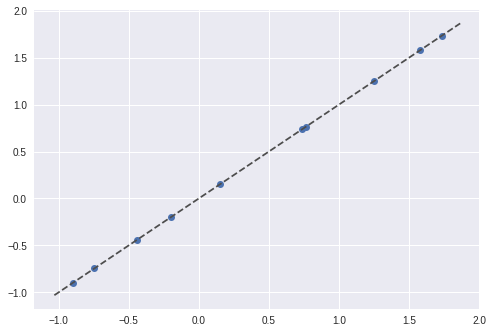

In [27]:
plt.plot(weights_initial_GD[random_indices], weights_initial_GD[random_indices], "o")
plt.plot(plt.xlim(), plt.xlim(), ls="--", c=".3")


### Compare the analytical expression of the weights to the actual training of the network.

Train the net:

In [0]:
n_epochs = 10000

In [29]:
%%time
train_net(net, n_epochs, input_data, target_data)

CPU times: user 23.7 s, sys: 1.09 s, total: 24.8 s
Wall time: 25.1 s


In [0]:
weights_GD = list(net.parameters())
weights_GD = unpack_weights(weights_GD).detach().cpu().numpy()

Analytical evolution:

In [31]:
weights_analytical = weight_analytical_evolution_MSE(n_epochs, lr, theta_0, initial_train, target_data, grad_tensor) + weights_initial_GD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


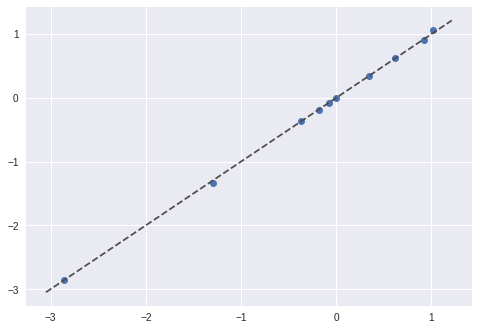

In [32]:
plt.plot(weights_GD[random_indices], weights_analytical[random_indices], "o")
plt.plot(plt.xlim(), plt.xlim(), ls="--", c=".3")


See if the weights actually changed at all during training: they do not change much!

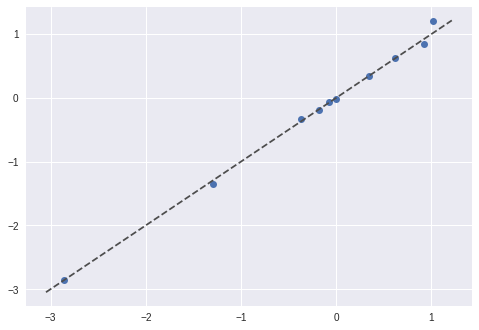

In [33]:
plt.plot(weights_GD[random_indices], weights_initial_GD[random_indices], "o")
plt.plot(plt.xlim(), plt.xlim(), ls="--", c=".3")

### Compute the evolution of the prediction on the trainset:

In [0]:
def prediction_train_analytical_evolution_MSE(t, lr, theta_0, initial_train, target_data): 
  # compute the analytical evolution of the predictions on the test set using equation 10 in the linearized network paper. 
  # This is valid for MSE loss. 
  
  # t -> time after you want to consider the weights
  # lr -> learning rate
  # initial_train -> prediction using the initial value of the network. 
  # target data -> ground truth of the training points
  
  # first compute the exponential of the matrix (using eigendecomposition): 
  lam, P = eig(theta_0)  # eig decomposition
  lam = lam.astype(dtype = 'float64')

  exp_matrix = np.dot(P, np.dot(np.diag(np.exp(-lr * t * lam)), P.transpose()))  # I am using np arrays, not torch tensors

  # now perform all the matrix multiplications from right to left (more efficient):
  pred = target_data.cpu().numpy() + np.dot(exp_matrix, (initial_train - target_data).cpu().detach().numpy())
  
  return(pred)

### Compute the evolution on the test set. For this, you also need the testvtrain kernel

In [0]:
def prediction_test_analytical_evolution_MSE(t, lr, theta_0, theta_0_test, initial_train, initial_test, target_data): 
  # compute the analytical evolution of the predictions on the test set using equation 10 in the linearized network paper. 
  # This is valid for MSE loss. 
  
  # t -> time after you want to consider the weights
  # lr -> learning rate
  # initial_train -> prediction using the initial value of the network. 
  # target data -> ground truth of the training points
  
  # first compute the exponential of the matrix (using eigendecomposition): 
  lam, P = eig(theta_0)  # eig decomposition
  lam = lam.astype(dtype = 'float64')
  
  theta_0_inv = np.dot(P, np.dot(np.diag(lam**(-1)), P.transpose())) 
  
  exp_matrix = np.dot(P, np.dot(np.diag(np.exp(-lr * t * lam)), P.transpose()))  # I am using np arrays, not torch tensors

  # now perform all the matrix multiplications from right to left (more efficient):
  pred = np.dot(np.eye(lam.size) - exp_matrix, (initial_train - target_data).cpu().detach().numpy())
  pred = np.dot(theta_0_inv, pred)
  pred = np.dot(theta_0_test , pred)
  pred = initial_test.detach().cpu().numpy().reshape(-1) - pred

  return(pred)

## Next step is reproducing plots as in Fig. 4 in the linearized network paper, where you see the evolution of the weights and predictions during training.

Before running this, you need again to initialize the network and compute all the quantities at starting time. 

In [0]:
n_width = 1000
# instanciate network
net = FourLayersNet(n_width)
if use_cuda:
  net.cuda()

In [0]:
initial_train = net(input_data).reshape(-1) # this acts of f_0. Reshape removes the dummy dimension.
initial_test = net(test_data)

In [164]:
%%time
grad_list = compute_grad_list(gamma_data)

CPU times: user 20.3 ms, sys: 2.66 ms, total: 23 ms
Wall time: 25.5 ms


In [165]:
%%time
grad_tensor = unpack_gradients(grad_list)
n_parameters = grad_tensor.shape[1]

CPU times: user 72.9 ms, sys: 6.35 ms, total: 79.3 ms
Wall time: 82.1 ms


Use the function to compute both kernels. `theta_0_test` is the kernel between test data and train data. 

In [166]:
%%time
theta_0_test, theta_0 = kernel_mats(net, gamma_data, gamma_test, use_cuda=use_cuda, kernels='both')  

K_testvtrain is 10% complete
K_testvtrain is 20% complete
K_testvtrain is 30% complete
K_testvtrain is 40% complete
K_testvtrain is 50% complete
K_testvtrain is 60% complete
K_testvtrain is 70% complete
K_testvtrain is 80% complete
K_testvtrain is 90% complete
K_testvtrain is 100% complete
CPU times: user 64.6 ms, sys: 13.2 ms, total: 77.8 ms
Wall time: 81.2 ms


In [167]:
%%time
# extract the initial weights from the net
weights_initial_GD = list(net.parameters())
weights_initial_GD = unpack_weights(weights_initial_GD).detach().cpu().numpy()

CPU times: user 4.54 ms, sys: 783 µs, total: 5.32 ms
Wall time: 5.78 ms


Now set the max time horizon and the stepsize. You also need to select the position of the elements of which you will keep track. 

In [0]:
lr = 1
t_max = 100
t_step = 1
n_weights_to_track = 10

random_indices = np.random.randint(0, n_parameters, n_weights_to_track)
t_list = np.arange(0, t_max, t_step)

weights_GD_evolution = np.zeros((n_weights_to_track, len(t_list)))
weights_analytical_evolution = np.zeros((n_weights_to_track, len(t_list)))

preds_train_GD_evolution = np.zeros((n_train, len(t_list)))
preds_train_analytical_evolution = np.zeros((n_train, len(t_list)))

preds_test_GD_evolution = np.zeros((n_test, len(t_list)))
preds_test_analytical_evolution = np.zeros((n_test, len(t_list)))

Every iteration, you train the network for `t_step` and compute the evolution of the weights after that amount of steps, as well as the prediction on the train set. Note that actually we are computing the change in the weights, and not the weigthts themselves . 

In [173]:
training_time = 0
analytical_time = 0

for i, t in tqdm(enumerate(t_list)): 
  
  # train network
  start_time = time.time()
  train_net(net, t_step, input_data, target_data, lr=lr)
  
  # extract_weights
  weights_GD = list(net.parameters())
  weights_GD = unpack_weights(weights_GD).detach().cpu().numpy()
  
  # save the interesting ones: 
  weights_GD_evolution[:, i] = weights_GD[random_indices] - weights_initial_GD[random_indices]

  # compute the preciction on the trainset at this point of the training: 
  preds_train_GD_evolution[:, i] = net(input_data).detach().cpu().reshape(-1)
  
  # same on the testset: 
  preds_test_GD_evolution[:, i] = net(test_data).detach().cpu().reshape(-1)  
  training_time += time.time() - start_time
  
      
  # now compute the analytical evolution: 
  # this is extremely efficient as at every step we compute the eigendecomposition and some matrix multiplication that remain the same with different t, but I don't care up to now. 
  # Moreover, the 3 different functions repeat the same operation. But actually the analytical computation is much faster than the GD one. 
  start_time = time.time()
  weights_analytical_evolution[:, i] = weight_analytical_evolution_MSE(t, lr, theta_0, initial_train, target_data, grad_tensor[:, random_indices]) 
  preds_train_analytical_evolution[:, i] = prediction_train_analytical_evolution_MSE(t, lr, theta_0, initial_train, target_data)
  preds_test_analytical_evolution[:, i] = prediction_test_analytical_evolution_MSE(t, lr, theta_0, theta_0_test, initial_train, initial_test, target_data)
  analytical_time += time.time() - start_time

print("\nTraining time: {:.2f}, analytical computation time: {:.2f}.".format(training_time, analytical_time))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
100it [00:01, 81.95it/s]


Training time: 1.03, analytical computation time: 0.16.


Now generate plot. First cell defines a color map from which extract colors

In [0]:
cmap = plt.cm.nipy_spectral

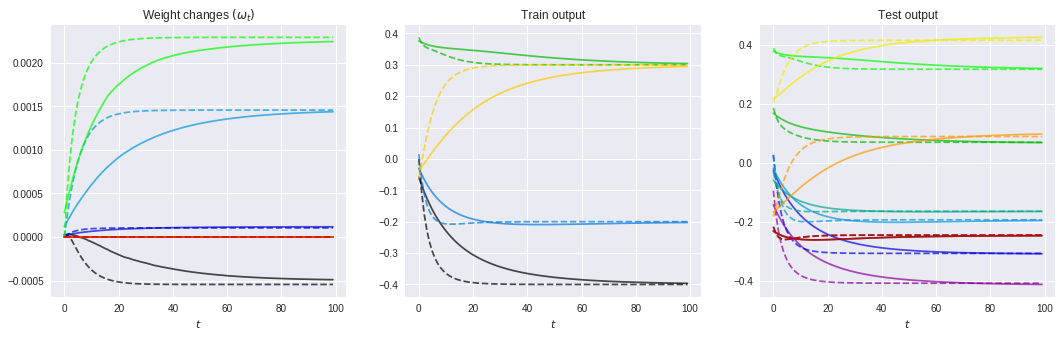

In [175]:
alpha = 0.7

fig, ax = plt.subplots(1,3, figsize=(18,5))

for i in range(n_weights_to_track):  
  ax[0].set_title(r"Weight changes $(\omega_t)$")
  ax[0].set_xlabel(r"$t$")
  ax[0].plot(t_list, weights_analytical_evolution[i], "--", color=cmap(i/n_weights_to_track), alpha=alpha)
  ax[0].plot(t_list, weights_GD_evolution[i], color=cmap(i/n_weights_to_track), alpha=alpha)
  
  
for i in range(n_train):
  ax[1].set_title(r"Train output")
  ax[1].set_xlabel(r"$t$")
  ax[1].plot(t_list, preds_train_analytical_evolution[i], "--", color=cmap(i/n_train), alpha=alpha)
  ax[1].plot(t_list, preds_train_GD_evolution[i], color=cmap(i/n_train), alpha=alpha)
  
for i in range(n_test):
  ax[2].set_title(r"Test output")
  ax[2].set_xlabel(r"$t$")
  ax[2].plot(t_list, preds_test_analytical_evolution[i], "--", color=cmap(i/n_test), alpha=alpha)
  ax[2].plot(t_list, preds_test_GD_evolution[i], color=cmap(i/n_test), alpha=alpha)
  
  
#ax[0].legend()